# skip-gram

Skip-Gram是给定input word来预测上下文。而CBOW是给定上下文，来预测input word.

In [30]:
from __future__ import print_function #表示不管哪个python版本，使用最新的print语法
import collections
import math
import numpy as np
import random
# import tensorflow as tf
import tensorflow.compat.v1 as tf
import zipfile
from matplotlib import pylab
from sklearn.manifold import TSNE

In [31]:
%matplotlib inline

In [28]:
def read_data(filename):
    """
    Extract the first file enclosed in a zip file as a list of words
    """
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split() # f.read返回字节，tf.compat.as_str将字节转为字符
    return data

#words里面包含了所有的单词
words = read_data('./data/text8.zip')
print('Data size %d' % len(words))

Data size 17005207


创建正-反词典，并将单词转换为词典索引，这里词汇表取为50000，仍然有400000多的单词标记为unknown。

In [29]:
vocabulary_size = 50000 #词汇表大小

def build_dataset(words):
    count = [['UNK', -1]] # 未知，即不在词汇表里的单词
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1)) 
    
    #词-索引哈希
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary) # 每增加一个-->len+1，索引从0开始
  
    data = list() # 用索引表示的整个text8文本
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
  
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))  # 索引-词哈希  
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


生成batch的函数

In [14]:
data_index = 0

# num_skips表示在两侧窗口内总共取多少个词，数量可以小于2*skip_window
# span窗口为[ skip_window target skip_window ]
# num_skips=2*skip_window
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  
  #这里两个断言
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window

  #初始化batch和labels，都是整形
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32) #注意labels的形状
  
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  #buffer这个队列太有用了，不断地保存span个单词在里面，然后不断往后滑动，而且buffer[skip_window]就是中心词
  buffer = collections.deque(maxlen=span)
  
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  
  #需要多少个中心词，因为一个target对应num_skips个的单词，即一个目标单词w在num_skips=2时形成2个样本(w,left_w),(w,right_w)
    #     这样描述了目标单词w的上下文
  center_words_count=batch_size // num_skips
  for i in range(center_words_count):
    #skip_window在buffer里正好是中心词所在位置
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):  
#     选取span窗口中不包含target的，且不包含已选过的
      target=random.choice([i for i in range(0,span) if i not in targets_to_avoid])
      targets_to_avoid.append(target)
#         batch中重复num_skips次
      batch[i * num_skips + j] = buffer[skip_window]
#         同一个target对应num_skips个上下文单词
      labels[i * num_skips + j, 0] = buffer[target]
#     buffer滑动一格
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

# 打印前8个单词
print('data:', [reverse_dictionary[di] for di in data[:10]])
for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=16, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(16)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term', 'of', 'of', 'abuse', 'abuse', 'first', 'first', 'used', 'used']
    labels: ['anarchism', 'as', 'originated', 'a', 'as', 'term', 'of', 'a', 'abuse', 'term', 'of', 'first', 'abuse', 'used', 'against', 'first']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a', 'term', 'term', 'term', 'term', 'of', 'of', 'of', 'of']
    labels: ['a', 'originated', 'anarchism', 'term', 'of', 'as', 'term', 'originated', 'as', 'abuse', 'of', 'a', 'abuse', 'a', 'first', 'term']


> 一个target单词多次对应于其上下文的单词

# 构建model，定义loss

In [15]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.

valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
#随机挑选一组单词作为验证集，valid_examples也就是下面的valid_dataset，是一个一维的ndarray
valid_examples = np.array(random.sample(range(valid_window), valid_size))

#trick：负采样数值
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

tf.disable_v2_behavior()

with graph.as_default(), tf.device('/cpu:0'):

  # 训练集和标签，以及验证集（注意验证集是一个常量集合）
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # 定义Embedding层，初始化。
  embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # train_dataset通过embeddings变为稠密向量，train_dataset是一个一维的ndarray
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)

  # Compute the softmax loss, using a sample of the negative labels each time.
  # 计算损失，tf.reduce_mean和tf.nn.sampled_softmax_loss
  loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.优化器，这里也会优化embeddings
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # 模型其实到这里就结束了，下面是在验证集上做效果验证
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:先对embeddings做正则化
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
  #验证集单词与其他所有单词的相似度计算
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
keep_dims is deprecated, use keepdims instead


# 开始训练

In [16]:
num_steps = 40001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, this_loss = session.run([optimizer, loss], feed_dict=feed_dict)
    
    average_loss += this_loss
#     每2000步计算一次平均loss
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
#         nearest = (-sim[i, :]).argsort()[1:top_k+1]
        nearest = (-sim[i, :]).argsort()[0:top_k+1]#包含自己试试
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  #一直到训练结束，再对所有embeddings做一次正则化，得到最后的embedding
  final_embeddings = normalized_embeddings.eval()

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Average loss at step 0: 7.611593
Nearest to i: i, hauser, callahan, fairtrade, anthropomorphic, powering, capricious, alvaro,
Nearest to no: no, historically, heapsort, bypassing, collating, nouveaux, woodlands, mismatch,
Nearest to world: world, codeword, sark, saving, erwin, linearly, handel, surjective,
Nearest to war: war, starbuck, inequality, buckley, rodr, cimmeria, attila, jose,
Nearest to would: would, heights, dramatists, stolen, playoff, arendt, surfer, futuristic,
Nearest to states: states, cond, unintelligible, acadian, moldova, notably, zy, pokemon,
Nearest to after: after, miss, maldivian, sein, disaccharide, exoskeleton, courageous, drexel,
Nearest to while: while, sacd, anabaptism, cask, fogo, perturbed, supremely, nosferatu,
Nearest to or: or, vma, stormed, member, streptococcus, eurofighter, supporting, prototype,
Nearest to s: s, rainier, tamer, humanism, userbase, hplc, colloquial

我们可以看下训练过程中的验证情况. 当达到step 40000步时，可以看到此时单词的相似度确实很高了。
```text
Average loss at step 40000: 3.427624
Nearest to i: i, ii, you, we, t, tica, sailing, sliced,
Nearest to no: no, any, couples, endo, than, gnawing, expensive, another,
Nearest to world: world, circumvent, vaughan, time, robinson, dahl, laodicea, mecklenburg,
Nearest to war: war, inequality, starbuck, rodr, rossini, epimenides, kumamoto, subdisciplines,
Nearest to would: would, could, will, may, can, should, might, must,
Nearest to states: states, nations, unintelligible, cumulant, organically, irl, today, kingdom,
Nearest to after: after, before, when, during, erinyes, flawed, sheehan, mesh,
Nearest to while: while, although, but, when, were, distributive, before, are,
Nearest to or: or, and, than, a, nagpur, uploads, deserve, ro,
Nearest to s: s, his, esteban, delimitation, her, suo, fingerings, ljubljana,
Nearest to are: are, were, have, is, include, these, while, be,
Nearest to will: will, can, would, could, may, must, might, should,
Nearest to there: there, they, it, he, we, usually, which, often,
Nearest to at: at, during, punched, on, in, near, dxm, bligh,
Nearest to known: known, used, such, ils, well, regarded, considered, deduction,
Nearest to american: american, australian, german, french, british, irish, russian, earthworm,
```

最后，我们通过降维，将单词相似情况以图示展现出来：

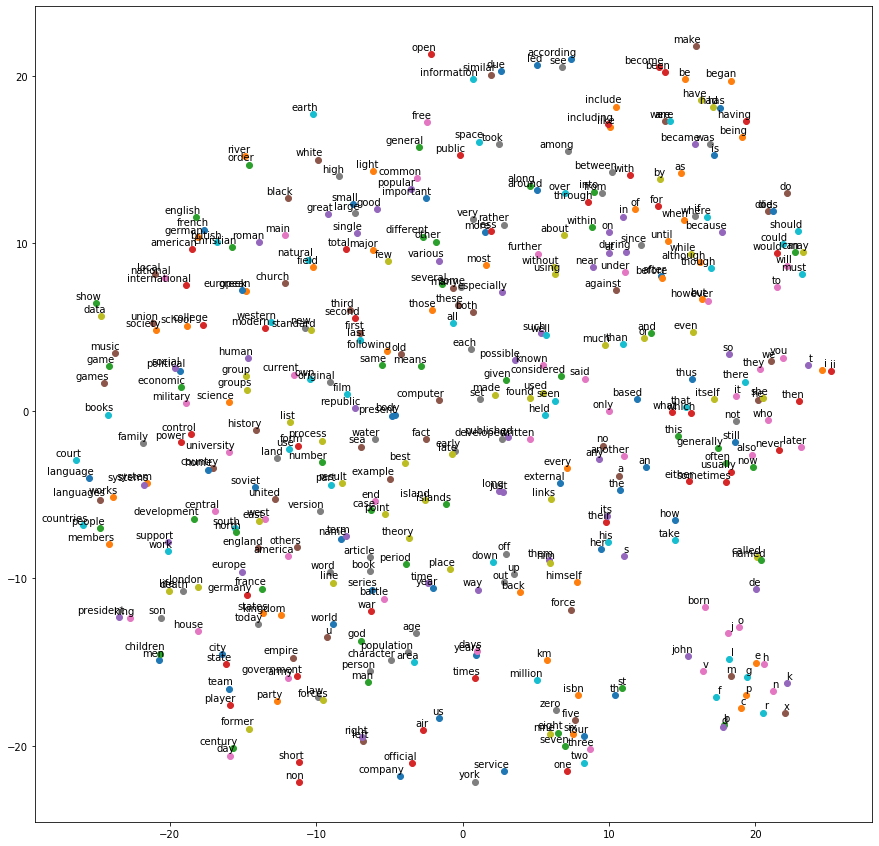

In [17]:
num_points = 400
# 降维度PCA
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)